# Code Explanation and Examples

## Introduction

In this notebook, we will discuss and illustrate the implementation of using the CausalBO package. We will provide explanations along with code samples to help you understand the key concepts and steps involved in the code.

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Code Explanation](#code-explanation)
    1. [Standard CBO Loop](#standard-cbo)
        1. [Importing Libraries](#s-importing-libraries)
        2. [Loading Data](#s-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#s-cbo-alg)
    2. [Custom CBO Loop](#custom-alg)
        1. [Importing Libraries](#c-importing-libraries)
        2. [Loading Data](#c-loading-data)
        3. [Causal Bayesian Optimization Algorithm](#c-cbo-alg)
3. [Result Replication](#result-replication)
## Prerequisites <a name="prerequisites"></a>

Before running the code samples, ensure you have the necessary libraries installed. Installing CausalBO through pip will ensure these dependencies are installed. Otherwise, you can run the following code to install them:

In [3]:
import sys
from tqdm import tqdm
!{sys.executable} -m pip install "numpy>=1.23.5" "pandas>=1.5.3" "torch>=2.0.0" "scipy>=1.8.1" "botorch>=0.8.3" "gpytorch>=1.9.1" "dowhy>=0.9.1" "networkx>=2.8.8"


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Code Explanation <a name="code-explanation"></a>

### Standard CBO Loop <a name="standard-cbo"></a>

#### Step 1: Importing Libraries <a name="s-importing-libraries"></a>

Begin by importing all of the necessary libraries for running a simple causal Bayesian optimization task using the included algorithm.

In [4]:
from causalbo.cbo_loop import CBOLoop
from causalbo.sample_data.toy_graph import ToyGraph

#### Step 2: Loading Data <a name="s-loading-data"></a>

For the simplest example, some sample DAGs and associated datasets have been provided. We can load all of the data we need by instantiating one of these objects. The object contains information about the graph structure, ground truth functions, and a randomly generated set of noisy observational data.

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:03<00:00,  1.24s/it]


{'X': [-5, 5], 'Z': [-5, 20]}
          X            Z         Y
0 -6.222996   502.402252 -0.394346
1 -7.038921  1141.577026  0.085929
2 -4.065892    58.867569 -1.633324
3 -3.770901    42.610752 -0.822795
4 -4.002141    54.775501 -0.808959
5 -5.349957   211.410828  0.001139
6 -4.355156    78.383003 -0.506857
7 -4.391265    81.563881  1.649965
8 -5.554657   259.571533  1.528640
9 -3.689533    39.778332 -0.384044


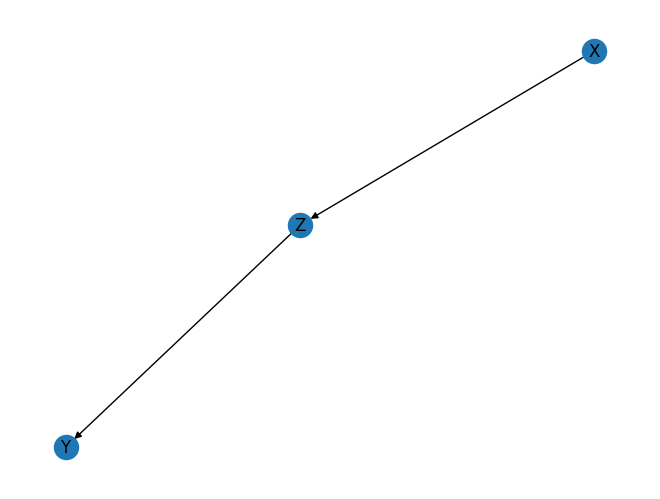

In [5]:
toy_graph = ToyGraph()

# Display sample data
toy_graph.draw()
print(toy_graph.interventional_domain)
print(toy_graph.observational_samples.head(10))

#### Step 3: Causal Bayesian Optimization Algorithm <a name="s-cbo-alg"></a>

Now, we can run the included CBO algorithm, originally developed by V. Aglietti et. al. and adapted for use in this package.

In [10]:
(global_optimum, global_optimal_set, gp, _, _, _, _) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=2, verbose=False)

print(global_optimum, global_optimal_set, gp)

Iteration 0
Current global optimal set-value-result = ['None']: None -> 3.9022717475891113
Observing 20 new data points.


Fitting causal mechanism of node Y:   0%|          | 0/3 [00:00<?, ?it/s]

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  5.64it/s]


Iteration 1
Current global optimal set-value-result = ['None']: None -> 3.9022717475891113
Intervening...
Iteration 2
Current global optimal set-value-result = ['X']: [-1.249485407024622] -> -1.7178023890455607
Intervening...
Iteration 3
Current global optimal set-value-result = ['X']: [-1.249485407024622] -> -1.7178023890455607
Intervening...
Iteration 4
Current global optimal set-value-result = ['X']: [-1.249485407024622] -> -1.7178023890455607
Intervening...
Early stopping reached max num of iters without improvment.
tensor(-1.7178, dtype=torch.float64) ['X'] SingleTaskGP(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (noise_prior): GammaPrior()
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): CausalMean()
  (covar_module): CausalRBF(
    (raw_lengthscale_constraint): Positive()
  )
)


### Custom CBO Loop <a name="custom-alg"></a>

It is also possible to use the provided modules to write a custom loop using BoTorch.

#### Importing Libraries <a name="c-importing-libraries"></a>

These imports will give access to the lower-level modules used in the simple example above to allow for the creation of a custom loop using BoTorch, as well as generating custom data.

In [5]:
from causalbo.modules import CausalMean, CausalRBF
from causalbo.do_calculus import SCM, E_output_given_do
from causalbo.causal_helper_funcs import *

from pandas import DataFrame

import torch
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

#### Loading Data <a name="c-loading-data"></a>

For this example, we will generate some custom data using the same DAG structure and ground truth functions provided in the ToyGraph import.

In [6]:
# Ground truth functions
def X(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return input_tensor + noise

def Z(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return (torch.exp(-input_tensor)) + noise

def Y(input_tensor, noise_mean=0, noise_stdev=0):
    input_tensor = input_tensor[..., :1]
    noise = torch.normal(noise_mean, noise_stdev, input_tensor.shape)
    return ((torch.cos(input_tensor)) - (torch.exp(-input_tensor / 20))) + noise

# Interventional domain = boundaries for each variable.
interventional_domain = {'X': [-5,5], 'Z': [-5,20]}

# Graph = DAG corresponding to causal connections.
# True Graph = Second SCM trained on objective data to perform interventions on
graph = SCM([('X', 'Z'), ('Z', 'Y')])
true_graph = SCM([('X', 'Z'), ('Z', 'Y')])

# Generate observational data
obs_data_x = X(torch.linspace(-5, 5, 1000).view(-1,1), noise_stdev=1)
obs_data_z = Z(obs_data_x, noise_stdev=1)
obs_data_y = Y(obs_data_z, noise_stdev=1)
# Add to dataframe
observational_samples = DataFrame()
observational_samples['X'] = torch.flatten(obs_data_x).tolist()
observational_samples['Z'] = torch.flatten(obs_data_z).tolist()
observational_samples['Y'] = torch.flatten(obs_data_y).tolist()
# Shuffle dataframe into random order
observational_samples.sample(frac=1)

# Generate objective data
obs_data_x = X(torch.linspace(-5, 5, 1000).view(-1,1))
obs_data_z = Z(obs_data_x)
obs_data_y = Y(obs_data_z)
# Add to dataframe
objective_samples = DataFrame()
objective_samples['X'] = torch.flatten(obs_data_x).tolist()
objective_samples['Z'] = torch.flatten(obs_data_z).tolist()
objective_samples['Y'] = torch.flatten(obs_data_y).tolist()

# Fit graphs to data
graph.fit(observational_samples)
true_graph.fit(objective_samples)

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:03<00:00,  1.13s/it]


#### Causal Bayesian Optimization Algorithm <a name="c-cbo-alg"></a>

With our data generated, we can now write a standard BoTorch optimization loop, and plug in the CausalRBF kernel and CausalMean mean functions, keeping everything else nearly identical to the non-causal implementation.

In [12]:
from causalbo.do_calculus import E_output_given_do, SCM
from causalbo.causal_helper_funcs import calculate_epsilon, subdict_with_keys, df_to_tensor
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from causalbo.modules import CausalMean, CausalRBF
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

NUM_INITIAL_OBSERVATIONS = 30 
INTERVENTION_COST = 10
OBSERVATION_COST = 1

toy_graph = ToyGraph()

num_initial_interventions = 1
num_iterations = 10

train_x_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns != toy_graph.graph.output_node])
train_y_standard = df_to_tensor(toy_graph.observational_samples.loc[:NUM_INITIAL_OBSERVATIONS,toy_graph.observational_samples.columns == toy_graph.graph.output_node])

# Store total cost
total_cost_standard = NUM_INITIAL_OBSERVATIONS
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Standard intervention set is all non-output nodes
intervention_set_standard = toy_graph.observational_samples.loc[:,toy_graph.observational_samples.columns != toy_graph.graph.output_node].columns.tolist()


# Initialize GP

gp_standard = SingleTaskGP(train_X=train_x_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

global_optimum_over_time_standard.append(global_optimum_standard)
cost_over_time_standard.append(total_cost_standard)

true_ys = torch.empty_like(train_y_standard)

# Optimization loop
for i in range(num_iterations):
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor(list(subdict_with_keys(toy_graph.interventional_domain, intervention_set_standard).values()), dtype=torch.float64).t(),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )
    

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = torch.tensor([[E_output_given_do(interventional_variable=intervention_set_standard, interventional_value=np.array(torch.flatten(new_x)), causal_model=toy_graph.true_graph)]])
    print(new_y)

    # Update the training data
    train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    true_ys = torch.cat([true_ys, new_y])


    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_x_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(true_ys)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST * len(intervention_set_standard)
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)

print(global_optimum_over_time_standard)


# Causal GP
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['Z']], # We are allowed to examine fewer variables here since we know the POMIS is ['Z'] and the causal GP can take advantage of this, while the standard cannot
        num_steps=10,
        num_initial_obs=NUM_INITIAL_OBSERVATIONS,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.true_graph,
        early_stopping_iters=10, verbose=True)


plt.plot([0] + cost_over_time_standard, [global_optimum_over_time_standard[0]] + global_optimum_over_time_standard, "-o")

plt.plot(cost_over_time_causal, global_optimum_over_time_causal, "-o")

plt.plot()

plt.legend(['Standard GP', 'Causal GP'])

plt.xlabel("Total Cost\nObservation costs 1 unit per point, intervention costs 10 units per variable")
plt.ylabel("Global Optimum")
plt.title("Standard GP vs Causal GP: Toy Graph, 10 iterations")
plt.show()

# # xs = np.arange(-5, 20, 0.1)
# # toy_graph.graph.fit(toy_graph.observational_samples)
# # ys = [E_output_given_do(interventional_variable=['Z'], interventional_value=[x], causal_model=toy_graph.graph) for x in xs]

# obj_func_x = torch.linspace(*toy_graph.interventional_domain['Z'], 1000).view(-1,1)
# obj_func_y = toy_graph.obj_func['X'](obj_func_x)
# true_optimum = torch.min(obj_func_y)
# plt.axhline(true_optimum, color='r')
# #plt.plot(obj_func_x, obj_func_y)
# #plt.plot(xs,ys)
# #plt.scatter(train_input_standard[:,0], train_y_standard)
# plt.plot(cost_over_time_standard, global_optimum_over_time_standard)
# # plt.plot(cost_over_time_causal, global_optimum_over_time_causal)
# plt.title('Causal GP vs Standard GP performance')
# plt.xlabel('Total Cost')
# plt.ylabel('Calculated Global Optimum')
# plt.legend(['True global optimum', 'Standard GP', 'Causal GP'])
# plt.show()

# # Ignore warnings regarding data scaling for simple example
# import warnings
# warnings.filterwarnings("ignore")
# import numpy as np

# train_x = torch.rand(5, 1)  # Random initial points
# train_y = Y(Z(X(train_x)))

# # Initialize the GP model
# gp = SingleTaskGP(train_x, train_y,
#                   covar_module=CausalRBF(
#                       interventional_variable=['X'],
#                       causal_model=graph
#                   ),
#                   mean_module=CausalMean(
#                       interventional_variable=['X'],
#                       causal_model=graph
#                   ))

# mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

# # Initialize the acquisition function (Expected Improvement)
# acq_fn = ExpectedImprovement(gp, best_f=0)

# # Bayesian optimization loop
# num_iterations = 5
# for iteration in range(num_iterations):
#     print(f"Iteration {iteration}")
#     # Optimize the acquisition function
#     candidate, _ = optimize_acqf(
#         acq_function=acq_fn,
#         bounds=torch.tensor(list(subdict_with_keys(interventional_domain, ['X']).values()), dtype=torch.float64).t(),
#         q=1,
#         num_restarts=5,
#         raw_samples=20,
#     )

#     # Evaluate the objective function at the new candidate point
#     new_x = candidate.detach()
#     new_y = torch.tensor([[E_output_given_do(interventional_variable=['X'], interventional_value=np.array(torch.flatten(new_x)), causal_model=true_graph)]])

#     # Update the training data
#     train_x = torch.cat([train_x, new_x])
#     train_y = torch.cat([train_y, new_y])

#     # Update the GP model and fit the hyperparameters
#     gp = SingleTaskGP(train_x, train_y,
#                   covar_module=CausalRBF(
#                       interventional_variable=['X'],
#                       causal_model=graph
#                   ),
#                   mean_module=CausalMean(
#                       interventional_variable=['X'],
#                       causal_model=graph
#                   ))
#     mll = ExactMarginalLogLikelihood(gp.likelihood, gp)

#     # Update the acquisition function with new observations
#     best_f = torch.max(train_y)
#     acq_fn = ExpectedImprovement(gp, best_f)

# # Retrieve the best-performing point
# best_point = train_x[torch.argmin(train_y)]

# print("Optimal Solution:", best_point.item())

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]


Standard GP, iteration 0
tensor([[-1.2165]], dtype=torch.float64)
Standard GP, iteration 1
tensor([[-0.8656]], dtype=torch.float64)
Standard GP, iteration 2
tensor([[-0.8567]], dtype=torch.float64)
Standard GP, iteration 3
tensor([[-1.4001]], dtype=torch.float64)
Standard GP, iteration 4
tensor([[-1.2156]], dtype=torch.float64)
Standard GP, iteration 5
tensor([[-1.3901]], dtype=torch.float64)
Standard GP, iteration 6
tensor([[-0.8683]], dtype=torch.float64)
Standard GP, iteration 7
tensor([[-1.3986]], dtype=torch.float64)
Standard GP, iteration 8
tensor([[-1.4063]], dtype=torch.float64)
Standard GP, iteration 9
tensor([[-1.3142]], dtype=torch.float64)
[3.786720037460327, tensor(-1.2165, dtype=torch.float64), tensor(-1.2165, dtype=torch.float64), tensor(-1.2165, dtype=torch.float64), tensor(-1.4001, dtype=torch.float64), tensor(-1.4001, dtype=torch.float64), tensor(-1.4001, dtype=torch.float64), tensor(-1.4001, dtype=torch.float64), tensor(-1.4001, dtype=torch.float64), tensor(-1.4063, 

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00, 19.15it/s]


Iteration 1
Current global optimal set-value-result = ['None']: None -> 2.539560079574585
Epsilon: 0 - Uniform: 0.06674840049356068
Intervening...
Optimal set-value pair: Z - [4.632018604315817]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = ['Z']: [4.632018604315817] -> -0.8843212364904341
Epsilon: 4.4996899409306676e-05 - Uniform: 0.40012067321565237
Intervening...
Optimal set-value pair: Z - [10.335165220312792]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 3
Current global optimal set-value-result = ['Z']: [10.335165220312792] -> -1.0637429905484859
Epsilon: 4.4996899409306676e-05 - Uniform: 0.8080618928705191
Intervening...
Optimal set-value pair: Z - [-0.8473423263058627]
Updating D_i for Z...
Updating GP posterior for Z...
Updating global optimum...
Iteration 4
Current global optimal set-value-result = ['Z']: [10.335165220312792] -> -1.06374299054848

KeyboardInterrupt: 

## Result Replication <a name='result-replication'></a>

### Toy Graph - Single Variable

Standard GP, iteration 0
Standard GP, iteration 1
Standard GP, iteration 2
Standard GP, iteration 3
Standard GP, iteration 4
Standard GP, iteration 5
Standard GP, iteration 6
Standard GP, iteration 7
Standard GP, iteration 8
Standard GP, iteration 9
Iteration 0
Current global optimal set-value-result = None: None -> 2.62973690032959
Epsilon: 1 - Uniform: 0.45441215307882443
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  6.01it/s]


Iteration 1
Current global optimal set-value-result = None: None -> 2.62973690032959
Epsilon: 0 - Uniform: 0.9535783635277885
Intervening...
Optimal set-value pair: X - [-1.1545216478407383]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.38003739796419705 - Uniform: 0.6330188793093804
Intervening...
Optimal set-value pair: X - [1.9150317753179298]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 3
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.38003739796419705 - Uniform: 0.761019747559948
Intervening...
Optimal set-value pair: X - [-1.0899318423551099]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Iteration 4
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.380037397964

Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Iteration 5
Current global optimal set-value-result = X: -1.1545216478407383 -> -1.8528382954337386
Epsilon: 0.42381540389613076 - Uniform: 0.5277769694458535
Intervening...
Optimal set-value pair: X - [-0.8997109828877364]
Updating D_i for X...
Updating GP posterior for X...
Updating global optimum...
Early stopping reached max num of iters without improvment.


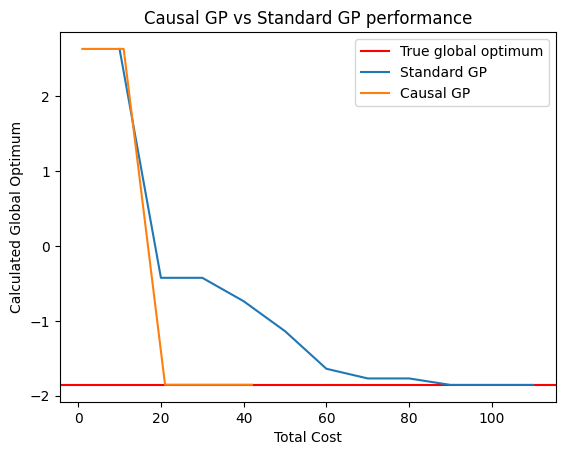

In [15]:
from causalbo.do_calculus import E_output_given_do, SCM
from causalbo.causal_helper_funcs import calculate_epsilon, subdict_with_keys
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from causalbo.modules import CausalMean, CausalRBF
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

toy_graph = ToyGraph()

num_initial_interventions = 1
num_iterations = 10

bounds = toy_graph.interventional_domain['X']
train_x_standard = torch.tensor([[random.uniform(*bounds)]])
train_y_standard = toy_graph.obj_func['X'](train_x_standard)


# Store total cost
total_cost_standard = 10
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Cost of intervening and observing
INTERVENTION_COST = 10
OBSERVATION_COST = 1

# Initialize GP

train_input_standard = train_x_standard

gp_standard = SingleTaskGP(train_X=train_input_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

global_optimum_over_time_standard.append(global_optimum_standard)
cost_over_time_standard.append(total_cost_standard)

# Optimization loop
for i in range(num_iterations):
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor([[-5.], [5.]]),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = toy_graph.obj_func['X'](new_x)

    # Update the training data
    train_input_standard = torch.cat([train_input_standard, new_x])
    # train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_input_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(train_y_standard)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)

# Causal GP
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.obj_func,
        early_stopping_iters=2, verbose=True)

# xs = np.arange(-5, 20, 0.1)
# toy_graph.graph.fit(toy_graph.observational_samples)
# ys = [E_output_given_do(interventional_variable=['Z'], interventional_value=[x], causal_model=toy_graph.graph) for x in xs]

obj_func_x = torch.linspace(*toy_graph.interventional_domain['Z'], 1000).view(-1,1)
obj_func_y = toy_graph.obj_func['X'](obj_func_x)
true_optimum = torch.min(obj_func_y)
plt.axhline(true_optimum, color='r')
#plt.plot(obj_func_x, obj_func_y)
#plt.plot(xs,ys)
#plt.scatter(train_input_standard[:,0], train_y_standard)
plt.plot(cost_over_time_standard, global_optimum_over_time_standard)
plt.plot(cost_over_time_causal, global_optimum_over_time_causal)
plt.title('Causal GP vs Standard GP performance')
plt.xlabel('Total Cost')
plt.ylabel('Calculated Global Optimum')
plt.legend(['True global optimum', 'Standard GP', 'Causal GP'])
plt.show()

### Toy Graph - Multi Variable

Iteration 0
Current global optimal set-value-result = None: None -> 2.212989330291748
Epsilon: 1 - Uniform: 0.023118117518107217
Observing 20 new data points.


Fitting causal mechanism of node Y: 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


Iteration 1
Current global optimal set-value-result = None: None -> 2.212989330291748
Epsilon: 0 - Uniform: 0.27883005677909145
Intervening...
Optimal set-value pair: ZX - [3.8609408121556044, 2.7578428108245134]
Updating D_i for ZX...
Updating GP posterior for ZX...
Updating global optimum...
Iteration 2
Current global optimal set-value-result = ZX: 3.8609408121556044 -> 0.0008303508749167854
Epsilon: 0.41986965681565175 - Uniform: 0.718570853325233
Intervening...
Optimal set-value pair: ZX - [3.074025483801961, -1.9032358285039663]
Updating D_i for ZX...
Updating GP posterior for ZX...
Updating global optimum...
Iteration 3
Current global optimal set-value-result = ZX: 3.8609408121556044 -> 0.0008303508749167854
Epsilon: 0.41986965681565175 - Uniform: 0.8104192449598988
Intervening...
Optimal set-value pair: ZX - [2.999539935695284, 2.760031919792293]
Updating D_i for ZX...
Updating GP posterior for ZX...
Updating global optimum...
Iteration 4
Current global optimal set-value-result 

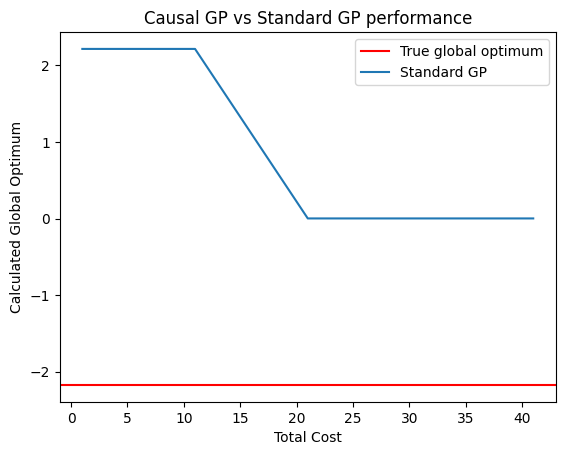

In [2]:
from causalbo.do_calculus import E_output_given_do, SCM
from causalbo.causal_helper_funcs import calculate_epsilon, subdict_with_keys
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from causalbo.modules import CausalMean, CausalRBF
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

toy_graph = ToyGraph()

# num_initial_interventions = 1
# num_iterations = 10

# bounds = toy_graph.interventional_domain['X']
# train_x_standard = torch.tensor([[random.uniform(*bounds)]])
# train_z_standard = ToyGraph.Z(train_x_standard)
# train_y_standard = toy_graph.obj_func['Y'](train_z_standard)


# # Store total cost
# total_cost_standard = 20
# # Store optimal value
# global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# # Store changes in cost over time
# cost_over_time_standard = []
# # Store optimum over time
# global_optimum_over_time_standard = []
# # Cost of intervening and observing
# INTERVENTION_COST = 10
# OBSERVATION_COST = 1

# # Initialize GP

# train_input_standard = torch.cat((train_x_standard, train_z_standard), dim=1)

# gp_standard = SingleTaskGP(train_X=train_input_standard, train_Y=train_y_standard)
# mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
# acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
# fit_gpytorch_model(mll)

# global_optimum_over_time_standard.append(global_optimum_standard)
# cost_over_time_standard.append(total_cost_standard)

# # Optimization loop
# for i in range(num_iterations):
#     print(f'Standard GP, iteration {i}')
#     candidate, _ = optimize_acqf(
#         acq_function=acqf,
#         bounds=torch.tensor([[-5., -5.], [5., 20.]]),
#         q=1,
#         num_restarts=5,
#         raw_samples=20,
#     )

#     # Evaluate the objective function at the new candidate point
#     new_x = candidate.detach()
#     new_y = toy_graph.obj_func['Y'](new_x)

#     # Update the training data
#     train_input_standard = torch.cat([train_input_standard, new_x])
#     # train_x_standard = torch.cat([train_x_standard, new_x])
#     train_y_standard = torch.cat([train_y_standard, new_y])

#     # Update the GP model and fit the hyperparameters
#     gp_standard = SingleTaskGP(train_input_standard, train_y_standard)
#     mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
#     fit_gpytorch_model(mll)

#     # Update the acquisition function with new observations
#     global_optimum_standard = torch.min(train_y_standard)
#     acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

#     # Update cost and optimum
#     total_cost_standard += INTERVENTION_COST * 2
#     cost_over_time_standard.append(total_cost_standard)
#     global_optimum_over_time_standard.append(global_optimum_standard)

# Causal GP
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['Z', 'X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.obj_func,
        early_stopping_iters=2, verbose=True)

# xs = np.arange(-5, 20, 0.1)
# toy_graph.graph.fit(toy_graph.observational_samples)
# ys = [E_output_given_do(interventional_variable=['Z'], interventional_value=[x], causal_model=toy_graph.graph) for x in xs]

obj_func_x = torch.linspace(*toy_graph.interventional_domain['Z'], 1000).view(-1,1)
obj_func_y = toy_graph.obj_func['Y'](obj_func_x)
true_optimum = torch.min(obj_func_y)
plt.axhline(true_optimum, color='r')
#plt.plot(obj_func_x, obj_func_y)
#plt.plot(xs,ys)
#plt.scatter(train_input_standard[:,0], train_y_standard)
#plt.plot(cost_over_time_standard, global_optimum_over_time_standard)
plt.plot(cost_over_time_causal, global_optimum_over_time_causal)
plt.title('Causal GP vs Standard GP performance')
plt.xlabel('Total Cost')
plt.ylabel('Calculated Global Optimum')
plt.legend(['True global optimum', 'Standard GP', 'Causal GP'])
plt.show()

## Synthetic Graph

In [ ]:
from causalbo.do_calculus import E_output_given_do, SCM
from causalbo.causal_helper_funcs import calculate_epsilon, subdict_with_keys
import numpy as np
import torch
from matplotlib import pyplot as plt
from causalbo.sample_data.toy_graph import ToyGraph
from causalbo.cbo_loop import CBOLoop

from causalbo.modules import CausalMean, CausalRBF
from botorch.models import SingleTaskGP
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
from botorch.acquisition import ExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.optim import optimize_acqf
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

toy_graph = ToyGraph()

num_initial_interventions = 1
num_iterations = 10

bounds = toy_graph.interventional_domain['X']
train_x_standard = torch.tensor([[random.uniform(*bounds)]])
train_z_standard = ToyGraph.Z(train_x_standard)
train_y_standard = toy_graph.obj_func['Y'](train_z_standard)


# Store total cost
total_cost_standard = 20
# Store optimal value
global_optimum_standard = max(toy_graph.observational_samples[toy_graph.graph.output_node])
# Store changes in cost over time
cost_over_time_standard = []
# Store optimum over time
global_optimum_over_time_standard = []
# Cost of intervening and observing
INTERVENTION_COST = 10
OBSERVATION_COST = 1

# Initialize GP

train_input_standard = torch.cat((train_x_standard, train_z_standard), dim=1)

gp_standard = SingleTaskGP(train_X=train_input_standard, train_Y=train_y_standard)
mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)
fit_gpytorch_model(mll)

global_optimum_over_time_standard.append(global_optimum_standard)
cost_over_time_standard.append(total_cost_standard)

# Optimization loop
for i in range(num_iterations):
    print(f'Standard GP, iteration {i}')
    candidate, _ = optimize_acqf(
        acq_function=acqf,
        bounds=torch.tensor([[-5., -5.], [5., 20.]]),
        q=1,
        num_restarts=5,
        raw_samples=20,
    )

    # Evaluate the objective function at the new candidate point
    new_x = candidate.detach()
    new_y = toy_graph.obj_func['Y'](new_x)

    # Update the training data
    train_input_standard = torch.cat([train_input_standard, new_x])
    # train_x_standard = torch.cat([train_x_standard, new_x])
    train_y_standard = torch.cat([train_y_standard, new_y])

    # Update the GP model and fit the hyperparameters
    gp_standard = SingleTaskGP(train_input_standard, train_y_standard)
    mll = ExactMarginalLogLikelihood(gp_standard.likelihood, gp_standard)
    fit_gpytorch_model(mll)

    # Update the acquisition function with new observations
    global_optimum_standard = torch.min(train_y_standard)
    acqf = ExpectedImprovement(model=gp_standard, best_f=global_optimum_standard, maximize=False)

    # Update cost and optimum
    total_cost_standard += INTERVENTION_COST * 2
    cost_over_time_standard.append(total_cost_standard)
    global_optimum_over_time_standard.append(global_optimum_standard)

# Causal GP
(global_optimum, global_optimal_set, gp, D_i, D_o, cost_over_time_causal, global_optimum_over_time_causal) = CBOLoop(
        observational_samples=toy_graph.observational_samples,
        graph=toy_graph.graph,
        exploration_set=[['Z'], ['X']],
        num_steps=10,
        num_initial_obs=400,
        num_obs_per_step=20,
        num_max_allowed_obs=1000,
        interventional_domain=toy_graph.interventional_domain,
        type_trial='min',
        objective_function=toy_graph.obj_func,
        early_stopping_iters=2, verbose=True)

# xs = np.arange(-5, 20, 0.1)
# toy_graph.graph.fit(toy_graph.observational_samples)
# ys = [E_output_given_do(interventional_variable=['Z'], interventional_value=[x], causal_model=toy_graph.graph) for x in xs]

obj_func_x = torch.linspace(*toy_graph.interventional_domain['Z'], 1000).view(-1,1)
obj_func_y = toy_graph.obj_func['Y'](obj_func_x)
true_optimum = torch.min(obj_func_y)
plt.axhline(true_optimum, color='r')
#plt.plot(obj_func_x, obj_func_y)
#plt.plot(xs,ys)
#plt.scatter(train_input_standard[:,0], train_y_standard)
plt.plot(cost_over_time_standard, global_optimum_over_time_standard)
plt.plot(cost_over_time_causal, global_optimum_over_time_causal)
plt.title('Causal GP vs Standard GP performance')
plt.xlabel('Total Cost')
plt.ylabel('Calculated Global Optimum')
plt.legend(['True global optimum', 'Standard GP', 'Causal GP'])
plt.show()